In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Audio

In [3]:
!pip install tensorflow==2.12.1

ERROR: Could not find a version that satisfies the requirement tensorflow==2.12.1 (from versions: none)
ERROR: No matching distribution found for tensorflow==2.12.1


In [5]:
paths = []
labels = []
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[2]
        label = label.split('.')[0]
        labels.append(label.lower())

In [6]:
paths[0]

'/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_home_fear.wav'

In [7]:
labels[0]

'fear'

In [8]:
# creating a dataset
df = pd.DataFrame()
df['Speech'] = paths
df['labels'] = labels

In [9]:
df.head()

,Speech,labels
0,/kaggle/input/toronto-emotional-speech-set-tes...,fear
1,/kaggle/input/toronto-emotional-speech-set-tes...,fear
2,/kaggle/input/toronto-emotional-speech-set-tes...,fear
3,/kaggle/input/toronto-emotional-speech-set-tes...,fear
4,/kaggle/input/toronto-emotional-speech-set-tes...,fear


In [10]:
df.head(1901)

,Speech,labels
0,/kaggle/input/toronto-emotional-speech-set-tes...,fear
1,/kaggle/input/toronto-emotional-speech-set-tes...,fear
2,/kaggle/input/toronto-emotional-speech-set-tes...,fear
3,/kaggle/input/toronto-emotional-speech-set-tes...,fear
4,/kaggle/input/toronto-emotional-speech-set-tes...,fear
...,...,...
1896,/kaggle/input/toronto-emotional-speech-set-tes...,ps
1897,/kaggle/input/toronto-emotional-speech-set-tes...,ps
1898,/kaggle/input/toronto-emotional-speech-set-tes...,ps
1899,/kaggle/input/toronto-emotional-speech-set-tes...,ps


In [11]:
df['labels'].value_counts()

labels
fear       800
angry      800
disgust    800
neutral    800
sad        800
ps         800
happy      800
Name: count, dtype: int64

In [12]:
df.sample(4)

,Speech,labels
616,/kaggle/input/toronto-emotional-speech-set-tes...,disgust
5428,/kaggle/input/toronto-emotional-speech-set-tes...,ps
201,/kaggle/input/toronto-emotional-speech-set-tes...,angry
3531,/kaggle/input/toronto-emotional-speech-set-tes...,disgust


In [13]:
def wavelength(data, sr, emotion):
    plt.figure(figsize=(10,6))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def spectogram(data,sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(10,6))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()


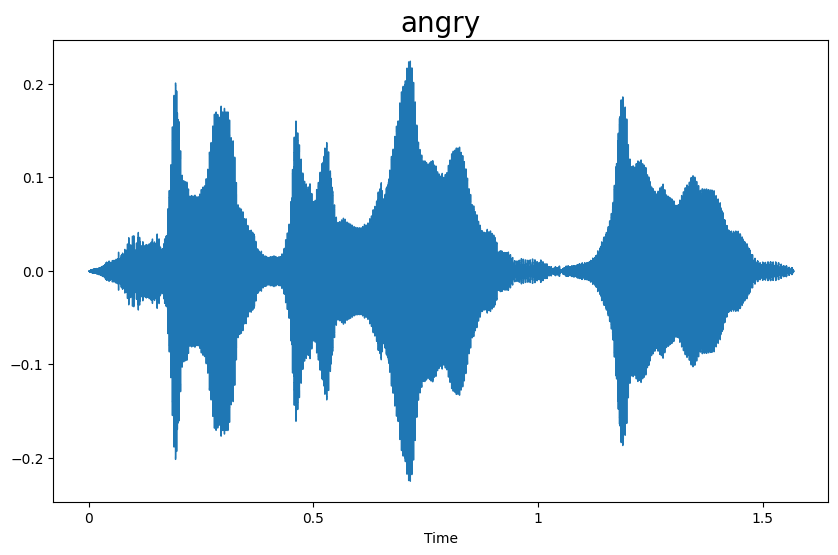

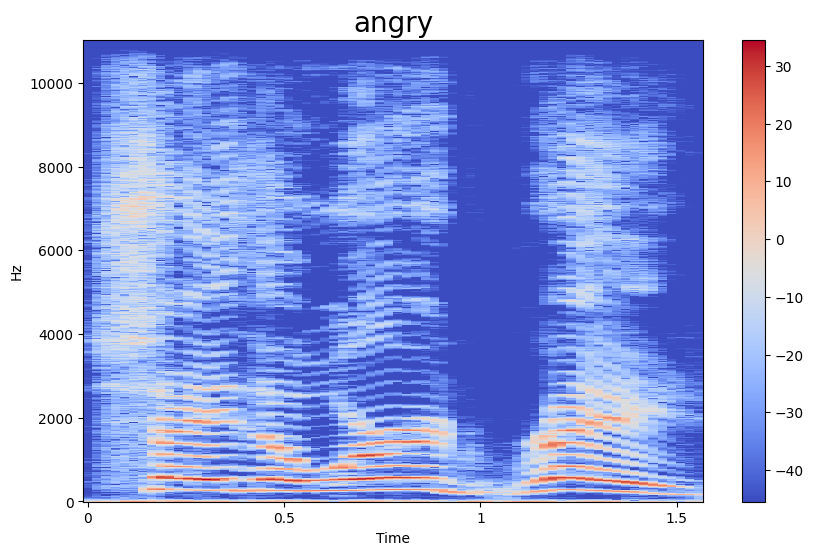

In [14]:
emotion = 'angry'
path = np.array(df['Speech'][df['labels'] == emotion])[0]
data, sampling_rate = librosa.load(path)
wavelength(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

In [15]:
def extract_feature(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc  = np.mean(librosa.feature.mfcc(y=y,sr=sr,n_mfcc=40).T, axis=0)
    return mfcc
    

In [16]:
X_mfcc = df['Speech'].apply(lambda x: extract_feature(x))

In [17]:
X_mfcc

0       [-285.73727, 85.78295, -2.1689117, 22.125532, ...
1       [-348.34332, 35.193233, -3.8413284, 14.658875,...
2       [-340.11435, 53.796444, -14.267782, 20.884031,...
3       [-306.63422, 21.259708, -4.4110823, 6.4871554,...
4       [-344.7548, 46.329193, -24.171413, 19.392921, ...
                              ...                        
5595    [-374.3952, 60.864998, 0.02505877, 8.431058, -...
5596    [-313.96478, 39.847843, -5.6493053, -3.8675754...
5597    [-357.54886, 77.88605, -15.224756, 2.194633, -...
5598    [-353.1474, 101.68391, -14.175897, -12.037376,...
5599    [-389.4595, 54.042767, 1.3469982, -1.4258989, ...
Name: Speech, Length: 5600, dtype: object

In [18]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

(5600, 40)

In [19]:
X = np.expand_dims(X, -1)
X.shape

(5600, 40, 1)

In [20]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
y = ohe.fit_transform(df[['labels']])

In [21]:
y=y.toarray()

In [22]:
y.shape

(5600, 7)

In [23]:

y[1900]

array([0., 0., 0., 0., 0., 1., 0.])

In [24]:
# creating model
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, LSTM, Dropout

In [25]:
model = Sequential()
model.add(LSTM(123, return_sequences=False, input_shape=(40, 1)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(7, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 123)            │        61,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         7,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,747 (280.26 KB)

 Trainable params: 71,747 (280.26 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
history = model.fit(X,y, validation_split=0.2, epochs=100, batch_size=512, shuffle=True)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 215ms/step - accuracy: 0.3052 - loss: 1.8274 - val_accuracy: 0.1937 - val_loss: 2.0084
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - accuracy: 0.4668 - loss: 1.4927 - val_accuracy: 0.1366 - val_loss: 1.8303
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - accuracy: 0.5740 - loss: 1.1627 - val_accuracy: 0.1777 - val_loss: 1.5883
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - accuracy: 0.7109 - loss: 0.8141 - val_accuracy: 0.4580 - val_loss: 1.1710
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step - accuracy: 0.7929 - loss: 0.5800 - val_accuracy: 0.6732 - val_loss: 0.8409
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - accuracy: 0.8458 - loss: 0.4543 - val_accuracy: 0.7616 - val_loss: 0.6405
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step - accuracy: 0.8834 - loss: 0.3479 - val_accuracy: 0.8259 - val_loss: 0.5154
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - accuracy: 0.9130 - loss: 0.2667 - val_accuracy: 0.8670 - v

In [27]:
predic = '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_Pleasant_surprise/OAF_back_ps.wav'
prediction = extract_feature(predic)

In [28]:
prediction = [x for x in prediction]
prediction = np.array(prediction)
prediction.shape

(40,)

In [29]:
prediction = np.expand_dims(prediction, -1)


In [30]:
prediction.shape

(40, 1)

In [31]:
prediction = prediction.reshape((1,40,1))

In [32]:
prediction.shape

(1, 40, 1)

In [33]:
index = np.argmax(model.predict(prediction))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


In [34]:
predictions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Pleasant Suprised', 'Sad']

In [35]:
print("model predicted ", predictions[index])

model predicted  Pleasant Suprised


In [190]:
import pickle
pickle.dump(model, open("SpeechReco.pkl", 'wb'))

In [191]:
print(f"Keras version: {keras.__version__}")
print(f"TensorFlow version: {tf.__version__}")

Keras version: 3.3.3
TensorFlow version: 2.16.1


In [1]:
print(f"Keras version: {keras.__version__}")
print(f"TensorFlow version: {tf.__version__}")


NameError: name 'keras' is not defined

In [37]:
model.save('sp.h5')

In [37]:
model.save('sp_model.keras')

In [38]:
if os.path.exists('sp.h5'):
    print('Model saved successfully')
else:
    print('Model not saved')

Model saved successfully


In [39]:
print(os.listdir(os.getcwd()))


['.virtual_documents', 'sp.h5']


In [38]:
print(python.__version__)

NameError: name 'python' is not defined

In [39]:
import sys
print(sys.version)


3.10.14 | packaged by conda-forge | (main, Mar 20 2024, 12:45:18) [GCC 12.3.0]
